In [ ]:
%%capture
!pip install efficientnet

In [ ]:
!pip list | grep tf

In [ ]:
!pip uninstall tf-nightly
!pip install tensorflow --upgrade --force-reinstall

  Using cached https://files.pythonhosted.org/packages/97/ae/0b08f53498417914f2274cc3b5576d2b83179b0cbb209457d0fde0152174/tensorflow-2.3.0-cp36-cp36m-manylinux2010_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/d6/84/759f5dd23fec8ba71952d97bcc7e2c9d7d63bdc582421f3cd4be845f0c98/gast-0.3.3-py2.py3-none-any.whl
Processing /root/.cache/pip/wheels/7c/06/54/bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6/termcolor-1.1.0-cp36-none-any.whl
  Using cached https://files.pythonhosted.org/packages/8c/23/848298cccf8e40f5bbb59009b32848a4c38f4e7f3364297ab3c3e2e2cd14/wheel-0.34.2-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ee/ff/48bde5c0f013094d729fe4b0316ba2a24774b3ff1c52d924a8a4cb04078a/six-1.15.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/2b/03/13dde6512ad7b4557eb792fbcf0c653af6076b81e5941d36ec61f7ce6028/astunparse-1.6.3-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/a3/de/c648ef68351

In [ ]:
import numpy as np
import pandas as pd
from efficientnet.keras import EfficientNetB7 as Net
from efficientnet.keras import center_crop_and_resize, preprocess_input
from tqdm.notebook import trange
import matplotlib.pyplot as plt

AttributeError: ignored

In [ ]:
train_csv = pd.read_csv('drive/My Drive/Kaggle Competition/SIIM-ISIC Melanoma Classification/train.csv')

In [ ]:
def train_test_split_by_patient_id(train_csv, val_size, X, y):
  patient_id = train_csv['patient_id'].values
  val_patients = np.random.choice(np.unique(patient_id), int(len(np.unique(patient_id))*val_size), False)
  train_patients = list(set(np.unique(patient_id)) - set(val_patients))
  train_index, val_index = [], []
  for i in range(len(train_csv)):
    if train_csv['patient_id'][i] in val_patients:
      val_index.append(i)
    if train_csv['patient_id'][i] in train_patients:
      train_index.append(i)
  X_train = np.memmap('X_train', mode='w+', dtype='uint8', shape=(len(train_index), 256, 256, 3))
  y_train = np.zeros((len(train_index)))
  X_val = np.memmap('X_val', mode='w+', dtype='uint8', shape=(len(val_index), 256, 256, 3))
  y_val = np.zeros((len(val_index)))


  for i in trange(len(train_index)):
    X_train[i] = X[train_index[i]]
    y_train[i] = y[train_index[i]]
  #temp = X_mem[train_index]
  #X_train[:] = temp[:]
  #del temp
  #y_train = y[train_index]

  for i in trange(len(val_index)):
    X_val[i] = X[val_index[i]]
    y_val[i] = y[val_index[i]]
  #temp = X_mem[val_index]
  #X_val[:] = temp[:]
  #del temp
  #y_val = y[val_index]

  return X_train, y_train, X_val, y_val

In [ ]:
def downsample_negative_class(X, y, ratio):
  if ratio == 1:
    return X, y
  neg_idx = list(np.where(y==0)[0])
  pos_idx = list(np.where(y==1)[0])
  shuffle = np.random.permutation(len(neg_idx))
  shuffle = shuffle[:len(neg_idx)//ratio]
  neg_idx = list(np.asarray(neg_idx)[shuffle])
  out_idx = pos_idx + neg_idx
  shuffle = np.random.permutation(len(out_idx))
  out_idx = np.asarray(out_idx)[shuffle]
  
  X_downsample_train = np.memmap('X_downsample_train', mode='w+', dtype='uint8', shape=(out_idx.shape[0], 256, 256, 3))
  y_downsample_train = np.zeros((y.shape), dtype='uint8')

  #temp = X[out_idx]
  for i in trange(X_downsample_train.shape[0]):
    X_downsample_train[i] = X[out_idx[i]]
    y_downsample_train[i] = y[out_idx[i]]
  
  return X_downsample_train, y_downsample_train

In [ ]:
def augment_positive_class(X, y):
    #X_pos = X[y==1]
    X_pos = np.zeros((len(y[y==1]), 256, 256, 3), dtype='uint8')
    pointer = 0
    for i in trange(X.shape[0]):
      if y[i] == 1:
        X_pos[pointer] = X[i]
        pointer += 1

    X_aug_train = np.memmap('X_aug_train', mode='w+', dtype='uint8', shape=(X.shape[0]+len(y[y==1])*7, 256, 256, 3))
    y_aug_train = np.ones((X_aug_train.shape[0]))
    for i in trange(X.shape[0]):
      X_aug_train[i] = X[i]
      y_aug_train[i] = y[i]
    #X_aug_train[:X.shape[0]] = X[:]
    for i in range(len(y[y==1])):
      X_aug_train[X.shape[0]+7*i] = np.flip(X_pos[i], axis=1)
      X_aug_train[X.shape[0]+7*i+1] = np.rot90(X_pos[i])
      X_aug_train[X.shape[0]+7*i+2] = np.rot90(np.flip(X_pos[i], axis=1))
      X_aug_train[X.shape[0]+7*i+3] = np.rot90(X_pos[i], 2)
      X_aug_train[X.shape[0]+7*i+4] = np.rot90(np.flip(X_pos[i], axis=1), 2)
      X_aug_train[X.shape[0]+7*i+5] = np.rot90(X_pos[i], 3)
      X_aug_train[X.shape[0]+7*i+6] = np.rot90(np.flip(X_pos[i], axis=1), 3)

    #shuffle = np.random.permutation(X_aug_train.shape[0])
    #temp = np.zeros((X_aug_train.shape), dtype='uint8')
    #for i in trange(X_aug_train.shape[0]):
    #  temp[i] = X_aug_train[shuffle[i]]
    #temp = X_aug_train[shuffle]
    #for i in trange(temp.shape[0]):
    #  X_aug_train[i] = temp[i]
    #X_aug_train[:] = temp[:]
    #del temp
    #temp = y_aug_train[shuffle]
    #y_aug_train = temp
    return X_aug_train, y_aug_train

In [ ]:
X_mem = np.load('drive/My Drive/Kaggle Competition/SIIM-ISIC Melanoma Classification/train_jpg.npy', mmap_mode='r')
y = np.array(train_csv["target"].values)

In [ ]:
%%time
X_train, y_train, X_val, y_val = train_test_split_by_patient_id(train_csv, 0.2, X_mem, y)


CPU times: user 6.72 s, sys: 8.27 s, total: 15 s
Wall time: 5min 53s


In [ ]:
%%time
#X_down_train, y_down_train = downsample_negative_class(X_train, y_train, 2)
X_down_train, y_down_train = downsample_negative_class(X_train, y_train, 1)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.58 µs


In [ ]:
%%time
X_down_aug_train, y_down_aug_train = augment_positive_class(X_down_train, y_down_train)


CPU times: user 4.92 s, sys: 7.47 s, total: 12.4 s
Wall time: 2min 28s


In [ ]:
from tensorflow.keras.utils import Sequence
import math

# Here, `x_set` is list of path to the images
# and `y_set` are the associated classes.

class Generator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.shuffle = np.random.permutation(self.x.shape[0])

    def __len__(self):
        return math.ceil(self.x.shape[0] / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[self.shuffle[idx*self.batch_size : (idx+1)*self.batch_size]]
        batch_y = self.y[self.shuffle[idx*self.batch_size : (idx+1)*self.batch_size]]
        return batch_x, batch_y

    def on_epoch_end(self):
        shuffle = np.random.permutation(self.x.shape[0])


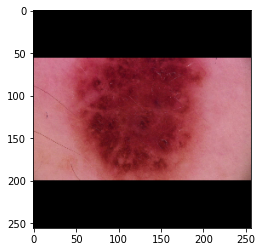

In [ ]:
plt.imshow(X_train[-1])

In [ ]:
dropout_rate = 0.5
input_shape = (256, 256, 3)

In [ ]:
conv_base = Net(weights="imagenet", include_top=False, input_shape=input_shape)

258441216/258434480 [==============================] - 3s 0us/step


In [ ]:
#from tensorflow.keras.utils import plot_model
#plot_model(conv_base, to_file='conv_base.png', show_shapes=True)
#from IPython.display import Image
#Image(filename='conv_base.png') 

In [ ]:
conv_base.trainable = False

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block7a_expand_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
from keras import models
from keras import layers
from keras import optimizers
from keras.metrics import Precision, Recall

model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
# model.add(layers.Flatten(name="flatten"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out"))
model.add(layers.Dense(64, activation='relu', name="fc1"))
#model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1, activation="sigmoid", name="fc_out"))

In [ ]:
import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
from keras import backend as K
import tensorflow as tf

import dill


def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

    return binary_focal_loss_fixed

In [ ]:
!pip install keras_radam
!pip install keras_lookahead
from keras_radam import RAdam
from keras_lookahead import Lookahead

  Created wheel for keras-radam: filename=keras_radam-0.15.0-cp36-none-any.whl size=14685 sha256=69ff4393739f5647d05e0cdd3bcd15090e3a4e1869f6016ed90ba16a14e015f2
  Stored in directory: /root/.cache/pip/wheels/79/a0/c0/670b0a118e8f078539fafec7bd02eba0af921f745660c7f83f
Successfully built keras-radam
  Created wheel for keras-lookahead: filename=keras_lookahead-0.9.0-cp36-none-any.whl size=6404 sha256=9609974e76643252a053e410fd9757ff7580d3a4d3c1a33dc51bfc6df2f7662a
  Stored in directory: /root/.cache/pip/wheels/80/e1/a7/027d1227307b7425941fe5b1a896f8a8b9556b432a2c540a07
Successfully built keras-lookahead


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[get_f1, Precision(), Recall(), 'acc'])
#model.compile(loss=binary_focal_loss(), optimizer=Lookahead(RAdam()), metrics=[get_f1, Precision(), Recall(), 'acc'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Model)      (None, 8, 8, 2560)        64097680  
_________________________________________________________________
gap (GlobalMaxPooling2D)     (None, 2560)              0         
_________________________________________________________________
dropout_out (Dropout)        (None, 2560)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 64)                163904    
_________________________________________________________________
fc_out (Dense)               (None, 1)                 65        
Total params: 64,261,649
Trainable params: 163,969
Non-trainable params: 64,097,680
_________________________________________________________________


In [ ]:
print(len(y_down_aug_train[y_down_aug_train==1]))
print(len(y_down_aug_train[y_down_aug_train==0]))
print(len(y_down_aug_train[y_down_aug_train==0])/(len(y_down_aug_train[y_down_aug_train==0])+len(y_down_aug_train[y_down_aug_train==1])))

3688
25817
0.8750042365700729


In [ ]:
print(len(y_val[y_val==1]))
print(len(y_val[y_val==0]))

123
6725


In [ ]:
history = model.fit(
    #X_mem, y, batch_size=64, epochs=3, validation_split=0.2#, class_weight={0:len(y[y==1])/len(y[y==1]), 1:len(y[y==0])/len(y[y==1])}
    Generator(X_down_aug_train, y_down_aug_train, 64), epochs=10, validation_data=Generator(X_val, y_val, 64), 
    class_weight={0:(1/len(y_down_aug_train[y_down_aug_train==0]))*(len(y_down_aug_train)/2.0), 1:(1/len(y_down_aug_train[y_down_aug_train==1]))*(len(y_down_aug_train)/2.0)}, 
    #use_multiprocessing=True, workers=4, max_queue_size=20
)

Epoch 1/10
462/462 [==============================] - 474s 1s/step - loss: 0.6061 - get_f1: 0.3741 - precision_1: 0.2506 - recall_1: 0.6757 - acc: 0.7068 - val_loss: 1.1519 - val_get_f1: 0.0356 - val_precision_1: 0.0217 - val_recall_1: 0.2602 - val_acc: 0.7763
Epoch 2/10
 67/462 [===>..........................] - ETA: 5:06 - loss: 0.4935 - get_f1: 0.4248 - precision_1: 0.3060 - recall_1: 0.6988 - acc: 0.7722

In [ ]:
#No class weight
Epoch 1/3
265/265 [==============================] - 1033s 4s/step - loss: 0.5031 - get_f1: 0.2987 - precision_1: 0.6399 - recall_1: 0.2357 - acc: 0.7994 - val_loss: 0.1538 - val_get_f1: 0.0314 - val_precision_1: 0.0246 - val_recall_1: 0.1081 - val_acc: 0.9099
Epoch 2/3
265/265 [==============================] - 991s 4s/step - loss: 0.3949 - get_f1: 0.5479 - precision_1: 0.7388 - recall_1: 0.4477 - acc: 0.8411 - val_loss: 0.4939 - val_get_f1: 0.0359 - val_precision_1: 0.0265 - val_recall_1: 0.1532 - val_acc: 0.8874
Epoch 3/3
265/265 [==============================] - 942s 4s/step - loss: 0.3830 - get_f1: 0.5738 - precision_1: 0.7563 - recall_1: 0.4749 - acc: 0.8483 - val_loss: 0.5017 - val_get_f1: 0.0296 - val_precision_1: 0.0175 - val_recall_1: 0.1622 - val_acc: 0.8268

In [ ]:
#class_weight={0:(1/len(y_down_aug_train[y_down_aug_train==0]))*(len(y_down_aug_train)/2.0), 1:(1/len(y_down_aug_train[y_down_aug_train==1]))*(len(y_down_aug_train)/2.0)}
Epoch 1/3
264/264 [==============================] - 1029s 4s/step - loss: 0.7131 - get_f1: 0.4019 - precision_1: 0.3648 - recall_1: 0.5141 - acc: 0.6975 - val_loss: 0.5450 - val_get_f1: 0.0559 - val_precision_1: 0.0338 - val_recall_1: 0.3197 - val_acc: 0.8103
Epoch 2/3
264/264 [==============================] - 986s 4s/step - loss: 0.5127 - get_f1: 0.5605 - precision_1: 0.4774 - recall_1: 0.6894 - acc: 0.7667 - val_loss: 1.6717 - val_get_f1: 0.0470 - val_precision_1: 0.0256 - val_recall_1: 0.4590 - val_acc: 0.6516
Epoch 3/3
264/264 [==============================] - 943s 4s/step - loss: 0.4844 - get_f1: 0.5753 - precision_1: 0.4911 - recall_1: 0.7062 - acc: 0.7753 - val_loss: 0.5890 - val_get_f1: 0.0469 - val_precision_1: 0.0283 - val_recall_1: 0.3443 - val_acc: 0.7588